### Now we define the Dataset and the Dataloader classes from pytorch

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
class CustomDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None, target_transform=None):
        self.X = np.load(images_path)
        self.y = np.load(labels_path)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        image = self.X[idx, :, :]
        label = self.y[idx]

        #convert to torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [3]:
images_path = "../data/processed/all_train_data.npy"
labels_path = "../data/processed/all_train_labels.npy"

#### load the dataset

In [4]:
train_data = CustomDataset(images_path, labels_path)

In [5]:
x_sample, y_sample = train_data.__getitem__(4) #display a random sample
print(x_sample)
print(y_sample)
print(f"Dataset length is {train_data.__len__()}")

tensor([[0.0135, 0.0074, 0.0147,  ..., 0.0025, 0.0086, 0.0172],
        [0.0037, 0.0012, 0.0110,  ..., 0.0086, 0.0037, 0.0061],
        [0.0074, 0.0123, 0.0135,  ..., 0.0147, 0.0061, 0.0184],
        ...,
        [0.0037, 0.0184, 0.0110,  ..., 0.0135, 0.0086, 0.0208],
        [0.0123, 0.0135, 0.0086,  ..., 0.0086, 0.0135, 0.0061],
        [0.0110, 0.0147, 0.0086,  ..., 0.0172, 0.0159, 0.0037]])
tensor(0)
Dataset length is 30000


#### Use the Dataloader wrapper

In [6]:
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)

Feature batch shape: torch.Size([16, 150, 150])
Labels batch shape: torch.Size([16])


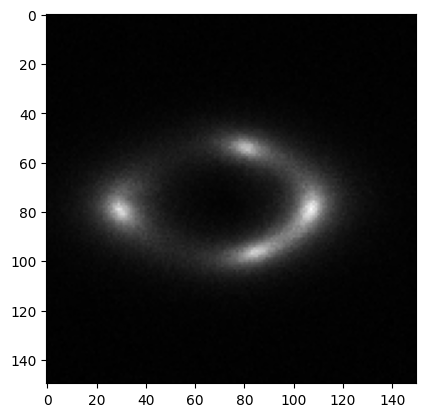

Label: 2


In [7]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

#### Now we develop a model, let's start simple and build a simple CNN model followed bc FC layers for classification. We can further improve this model to improve the baseline performance

In [16]:
import torch
from torch import nn

class CNNmodel(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNmodel, self).__init__()
        self.flatten = nn.Flatten()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128*18*18, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x): #x is 150x150 image
        x = self.cnn_layers(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

In [17]:
x = train_features[0].unsqueeze(0).unsqueeze(0)

In [18]:
x.shape

torch.Size([1, 1, 150, 150])

In [19]:
cnn = CNNmodel()
print(cnn)

CNNmodel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=41472, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3, bias=True)
  )
)


In [20]:
x_out = cnn(x)

In [21]:
x_out

tensor([[0.0513, 0.0539, 0.0323]], grad_fn=<AddmmBackward0>)

In [22]:
x_out.shape

torch.Size([1, 3])

#### Now we define a training loop

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    

In [29]:
for batch, (X, y) in enumerate(train_dataloader):
    print(batch)
    print(f"X = {X.shape}")
    print(f"y = {y}")
    break

0
X = torch.Size([16, 150, 150])
y = tensor([0, 0, 2, 2, 1, 0, 0, 0, 2, 1, 2, 1, 2, 1, 0, 1])


In [28]:
pred = cnn(X)

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[1, 16, 150, 150] to have 1 channels, but got 16 channels instead